### Importação das Bibliotecas

In [43]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import shap
shap.initjs()

### Estrutura dos Dados

<center>

|Feature|Tipo|Descrição|
|:--|:--|:--|
|Player|object|Nome do jogador|
|Pos|object|Posição do jogador (ex.: G para Armador, F para Ala, C para Pivô)|
|Age|int|Idade do jogador durante a temporada|
|Tm|object|Abreviação do time|
|G|int|Jogos disputados|
|GS|int|Jogos como titular|
|MP|float|Minutos jogados por partida|
|FG|float|Arremessos de quadra convertidos por partida|
|FGA|float|Arremessos de quadra tentados por partida|
|FG%|float|Porcentagem de arremessos de quadra (FG/FGA)|
|3P|float|Cestas de três pontos convertidas por partida|
|3PA|float|Cestas de três pontos tentadas por partida|
|3P%|float|Porcentagem de cestas de três pontos (3P/3PA)|
|2P|float|Cestas de dois pontos convertidas por partida|
|2PA|float|Cestas de dois pontos tentadas por partida|
|2P%|float|Porcentagem de cestas de dois pontos (2P/2PA)|
|eFG%|float|Porcentagem efetiva de arremessos de quadra, ajustada para arremessos de três pontos|
|FT|float|Lances livres convertidos por partida|
|FTA|float|Lances livres tentados por partida|
|FT%|float|Porcentagem de lances livres (FT/FTA)|
|ORB|float|Rebotes ofensivos por partida|
|DRB|float|Rebotes defensivos por partida|
|TRB|float|Total de rebotes por partida (ORB + DRB)|
|AST|float|Assistências por partida|
|STL|float|Roubos de bola por partida|
|BLK|float|Tocos por partida|
|TOV|float|Turnovers por partida|
|PF|float|Faltas pessoais por partida|
|PTS|float|Pontos marcados por partida|
|year|int|Ano da temporada|
|PER|float|Índice de Eficiência do Jogador (Player Efficiency Rating)|
|TS%|float|Porcentagem de arremessos verdadeiros|
|3PAr|float|Taxa de tentativas de três pontos|
|FTr|float|Taxa de tentativas de lance livre|
|ORB%|float|Porcentagem de rebotes ofensivos|
|DRB%|float|Porcentagem de rebotes defensivos|
|TRB%|float|Porcentagem total de rebotes|
|AST%|float|Porcentagem de assistências|
|STL%|float|Porcentagem de roubos de bola|
|BLK%|float|Porcentagem de tocos|
|TOV%|float|Porcentagem de turnovers|
|USG%|float|Porcentagem de uso|
|OWS|float|Vitórias compartilhadas ofensivas|
|DWS|float|Vitórias compartilhadas defensivas|
|WS|float|Total de vitórias compartilhadas|
|WS/48|float|Vitórias compartilhadas por 48 minutos|
|OBPM|float|Box Plus-Minus ofensivo|
|DBPM|float|Box Plus-Minus defensivo|
|BPM|float|Box Plus-Minus total|
|VORP|float|Valor acima do jogador substituto (Value Over Replacement Player)|
|Pts Won|float|Pontos ganhos|
|Pts Max|float|Pontos máximos possíveis|
|Share|float|Participação na votação de MVP (**nosso alvo**)|
|team|object|Nome do time|
|W|int|Vitórias|
|L|int|Derrotas|
|W/L%|float|Porcentagem de vitórias|
|GB|float|Jogos atrás do primeiro colocado|
|PS/G|float|Pontos marcados por partida pelo time|
|PA/G|float|Pontos sofridos por partida pelo time|
|SRS|float|Sistema de Classificação Simples (Simple Rating System)|

-----
### Importação

In [243]:
def read_data(fname):
    """
    Função de Importação do arquivo,
    Indentificando e removendo
    duplicatas,

    """
    df = pd.read_csv(fname)
    print("Data shape raw               : ", df.shape)
    num_duplicated = df.duplicated().sum()
    print("Number of duplicate order id : ",num_duplicated)
    df = df.drop_duplicates(keep='last')
    print("Data shape after dropping    : ", df.shape)
    print("Data shape final             : ", df.shape)
    return df

##### chamando a função de importação

In [244]:
data = read_data(fname='final_nba_1991_2024.csv')

Data shape raw               :  (15808, 62)
Number of duplicate order id :  0
Data shape after dropping    :  (15808, 62)
Data shape final             :  (15808, 62)


##### Visualizações iniciais do Dado

In [13]:
data.head()

,Unnamed: 0,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,Pts Max,Share,team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,0,Doc Rivers,PG,29,ATL,79,79,32.7,5.6,12.9,...,0.0,0.00,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
1,1,Dominique Wilkins,SF,31,ATL,81,81,38.0,9.5,20.2,...,960.0,0.03,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
2,2,Duane Ferrell,SF,25,ATL,78,2,14.9,2.2,4.6,...,0.0,0.00,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
3,3,Gary Leonard,C,23,ATL,4,0,2.3,0.0,0.0,...,0.0,0.00,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
4,4,John Battle,SG,28,ATL,79,2,23.6,5.0,10.9,...,0.0,0.00,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72


----------
### Pré-processamento

##### Removendo colunas desnecessárias

In [14]:
del data['Unnamed: 0']

##### Verificando as coluna antes de fazer a divisão 

In [15]:
data.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'year', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Pts Won', 'Pts Max', 'Share', 'team', 'W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS'],
      dtype='object')

##### Verificando o Tipo das Colunas

In [16]:
for col in data.columns:
    print(f"{col}: {data[col].dtype}")

Player: object
Pos: object
Age: int64
Tm: object
G: int64
GS: int64
MP: float64
FG: float64
FGA: float64
FG%: float64
3P: float64
3PA: float64
3P%: float64
2P: float64
2PA: float64
2P%: float64
eFG%: float64
FT: float64
FTA: float64
FT%: float64
ORB: float64
DRB: float64
TRB: float64
AST: float64
STL: float64
BLK: float64
TOV: float64
PF: float64
PTS: float64
year: int64
PER: float64
TS%: float64
3PAr: float64
FTr: float64
ORB%: float64
DRB%: float64
TRB%: float64
AST%: float64
STL%: float64
BLK%: float64
TOV%: float64
USG%: float64
OWS: float64
DWS: float64
WS: float64
WS/48: float64
OBPM: float64
DBPM: float64
BPM: float64
VORP: float64
Pts Won: float64
Pts Max: float64
Share: float64
team: object
W: int64
L: int64
W/L%: float64
GB: float64
PS/G: float64
PA/G: float64
SRS: float64


##### Como há muitos jogadores que atuam em diferentes posições (geralmente nos anos 2000), preciso reverter para a sua posição original. Por isso estou verificando todas as posições dos Jogadores

In [17]:
data['Pos'].unique()

array(['PG', 'SF', 'C', 'SG', 'PF', 'PF-SF', 'PG-SG', 'C-PF', 'SG-SF',
       'SG-PG', 'PF-C', 'SF-SG', 'SF-PF', 'SG-PF', 'SF-C', 'PG-SF',
       'SG-PG-SF'], dtype=object)

##### Pegando a primeira posição, pois era a sua posição inicial mais comum.

In [18]:
data['Pos'] = data['Pos'].apply(lambda x: x.split('-')[0])

##### Aplicando a função de divisão do dado, 2023 para treino e 2024 para teste

In [19]:
def split_train_valid_test(data,year_train,year_test):
    train = data[data['year'] <= year_train]
    test = data[data['year'] == year_test]

    return train,test 

In [20]:
train,test = split_train_valid_test(data,2023,2024)

##### Como o valor do MVP é decidido pelo o maior valor de votação para o MVP que é o Share, , Pts Won (Pontos ganhos), Pts Max (Pontos máximos possíveis) Já que o Share é a divsão de  *Pts Won/Pts Won*

##### Função que remove as colunas Share, Pts Won (Pontos ganhos), Pts Max (Pontos máximos possíveis) e imprimi o tamanho da divisão

In [21]:
def split_input_output(data_train,data_test,target_col,unused_col):
   
    y_train = data_train[target_col]
    X_train = data_train.drop(columns=[target_col] + unused_col)
    y_test = data_test[target_col]
    X_test = data_test.drop(columns=[target_col] + unused_col)
    
    print(f'X shape: {X_train.shape}')
    print(f'y shape: {y_train.shape}')
    print(f'X shape: {X_test.shape}')
    print(f'y shape: {y_test.shape}')
    
    return X_train, y_train, X_test, y_test


#### Aplicando na divisão a função que separa os dados de treinmaneto e teste nas variaveis de entrada (X_train, X_test) e saída (y_train, y_test). Usando a coluna Share como alvo e exluindo as demais colunas que é a Pts won e Pts Max

In [22]:
X_train, y_train, X_test, y_test = split_input_output(data_train=train, data_test=test,
                                        target_col='Share', 
                                        unused_col=['Pts Won', 'Pts Max'])

X shape: (15236, 58)
y shape: (15236,)
X shape: (572, 58)
y shape: (572,)


In [23]:
X_train.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,BPM,VORP,team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Doc Rivers,PG,29,ATL,79,79,32.7,5.6,12.9,0.435,...,1.9,2.6,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
1,Dominique Wilkins,SF,31,ATL,81,81,38.0,9.5,20.2,0.470,...,4.9,5.4,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
2,Duane Ferrell,SF,25,ATL,78,2,14.9,2.2,4.6,0.489,...,-2.4,-0.1,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
3,Gary Leonard,C,23,ATL,4,0,2.3,0.0,0.0,0.000,...,-5.2,0.0,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72
4,John Battle,SG,28,ATL,79,2,23.6,5.0,10.9,0.461,...,-0.9,0.5,Atlanta Hawks,43,39,0.524,18.0,109.8,109.0,0.72


In [24]:
y_train.head()

0    0.00
1    0.03
2    0.00
3    0.00
4    0.00
Name: Share, dtype: float64

#### Função de separação de dados numéricos e categóricos

In [25]:
def split_numerical_categorical(data, num_cols, cat_cols):
    ''' 
    Dividi o conjunto de dados numéricos e categóricos,   

    Parametros:
    -----------
    data : pd.DataFrame
        O dataframe de entrada contendo todas as colunas numericas e as colunas categóricas
    
    
    num_cols : Lista de string
        A lista de nomes em colunas em 'datas' correspondem as características numéricas
    
    cat_cols : Lista de string a lista de nomes de colunas em datas correspondem as caracteristicas categóricas.

    Retorno da função é:
    --------
    tupla de um pd.DataFrame:
        - numerical_data : pd.DataFrame
            Um dataframe contendo somente dados númericos.
        - categorical_data : pd.DataFrame
            E outro dataframe contendo somente dados categóricos.

    '''
    numerical_data = data[num_cols]
    categorical_data = data[cat_cols]
    print(f'Data num shape: {numerical_data.shape}')
    print(f'Data cat shape: {categorical_data.shape}')

    return numerical_data, categorical_data

#### Separando as colunas numéricas

In [26]:
num_column = ['Age','G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP','W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS']

#### Separação da coluna Pos (Posição do jogador) em treino de categorias. 

In [27]:
cat_column = ['Pos']

In [28]:
X_train_num, X_train_cat = split_numerical_categorical(data=X_train,num_cols=num_column,cat_cols=cat_column)

Data num shape: (15236, 53)
Data cat shape: (15236, 1)


#####  Selecionando melhor os tipos númericos

In [29]:
numerical_df = data[[col for col in data.columns if data[col].dtype in ['int64', 'float64']]]

#### Correlação com a Variavei Target Share

In [227]:
corr_num = numerical_df.corr()['Share']

In [228]:
corrShare = go.Figure()

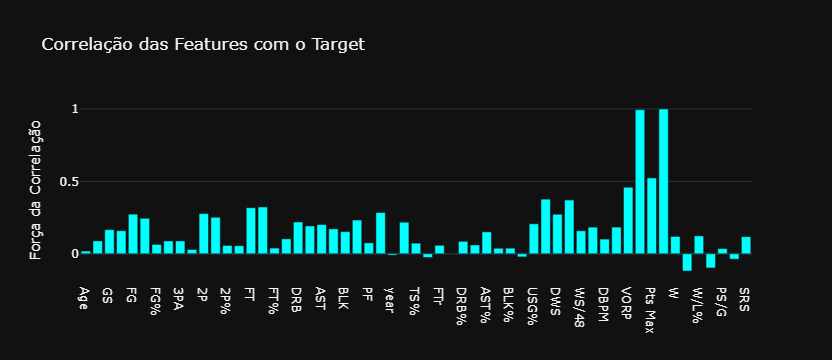

In [229]:
corrShare.add_trace(go.Bar(
    x=corr_num.index,   
    y=corr_num.values,   
    marker=dict(color='aqua')))

corrShare.update_layout(
    template='plotly_dark',
    title='Correlação das Features com o Target',
    yaxis_title='Força da Correlação')


#### Força da correlação com a Variavel Share (Target)

In [47]:
numerical_df.corr()['Share'].sort_values(ascending=False)

Share      1.000000
Pts Won    0.994688
Pts Max    0.523973
VORP       0.459215
OWS        0.377287
WS         0.371118
FTA        0.323242
FT         0.317960
PTS        0.284548
2P         0.277279
FG         0.273348
DWS        0.272826
2PA        0.252143
FGA        0.244928
TOV        0.232659
DRB        0.219480
PER        0.217912
USG%       0.207016
AST        0.201248
TRB        0.192050
OBPM       0.183999
BPM        0.183995
STL        0.171757
GS         0.166344
MP         0.159174
WS/48      0.158789
BLK        0.152507
AST%       0.150955
W/L%       0.123259
W          0.119591
SRS        0.117731
ORB        0.103043
DBPM       0.101434
G          0.088749
3PA        0.088520
3P         0.088044
DRB%       0.085870
PF         0.075212
TS%        0.073203
FG%        0.064402
TRB%       0.060705
FTr        0.058426
2P%        0.057327
eFG%       0.055552
FT%        0.039420
BLK%       0.038584
STL%       0.038032
PS/G       0.035801
3P%        0.029407
Age        0.018716


#### Concatenando os dados numéricos pelo o ano e pela votação do mvp

In [48]:
year_share_mvp = data.groupby('year')['Share'].max().reset_index()

In [49]:
data_mvp_by_year = pd.merge(data, year_share_mvp, on=['year', 'Share'])

In [50]:
data_mvp_by_year.sort_values('year', ascending=True)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Michael Jordan,SG,27,CHI,82,82,37.0,12.1,22.4,0.539,...,960.0,0.928,Chicago Bulls,61,21,0.744,0.0,110.0,101.0,8.57
1,Michael Jordan,SG,28,CHI,80,80,38.8,11.8,22.7,0.519,...,960.0,0.938,Chicago Bulls,67,15,0.817,0.0,109.9,99.5,10.07
26,Charles Barkley,PF,29,PHO,76,76,37.6,9.4,18.1,0.520,...,980.0,0.852,Phoenix Suns,62,20,0.756,0.0,113.4,106.7,6.27
13,Hakeem Olajuwon,C,31,HOU,80,80,41.0,11.2,21.2,0.528,...,1010.0,0.880,Houston Rockets,58,24,0.707,0.0,101.1,96.8,4.19
29,David Robinson,C,29,SAS,81,81,38.0,9.7,18.4,0.530,...,1050.0,0.858,San Antonio Spurs,62,20,0.756,0.0,106.6,100.6,5.90
2,Michael Jordan,SG,32,CHI,82,82,37.7,11.2,22.6,0.495,...,1130.0,0.986,Chicago Bulls,72,10,0.878,0.0,105.2,92.9,11.80
32,Karl Malone,PF,33,UTA,82,82,36.6,10.5,19.2,0.550,...,1150.0,0.857,Utah Jazz,64,18,0.780,0.0,103.1,94.3,7.97
3,Michael Jordan,SG,34,CHI,82,82,38.8,10.7,23.1,0.465,...,1160.0,0.934,Chicago Bulls,62,20,0.756,0.0,96.7,89.6,7.24
33,Karl Malone,PF,35,UTA,49,49,37.4,8.0,16.3,0.493,...,1180.0,0.701,Utah Jazz,37,13,0.740,0.0,93.3,86.8,5.54
15,Shaquille O'Neal,C,27,LAL,79,79,40.0,12.1,21.1,0.574,...,1210.0,0.998,Los Angeles Lakers,67,15,0.817,0.0,100.8,92.3,8.41


In [ ]:
len(data.columns)

61

### Estatisticas descritivas Básicas e Funções agg

#### Media de pontos por partidas de jogadores top 10

In [83]:
PTS = data_mvp_by_year.groupby('Player')['PTS'].median().sort_values().tail(10)
PTS

Player
LeBron James             27.75
Kobe Bryant              28.30
Giannis Antetokounmpo    28.60
Shaquille O'Neal         29.70
Michael Jordan           30.25
James Harden             30.40
Allen Iverson            31.10
Russell Westbrook        31.60
Kevin Durant             32.00
Joel Embiid              33.10
Name: PTS, dtype: float64

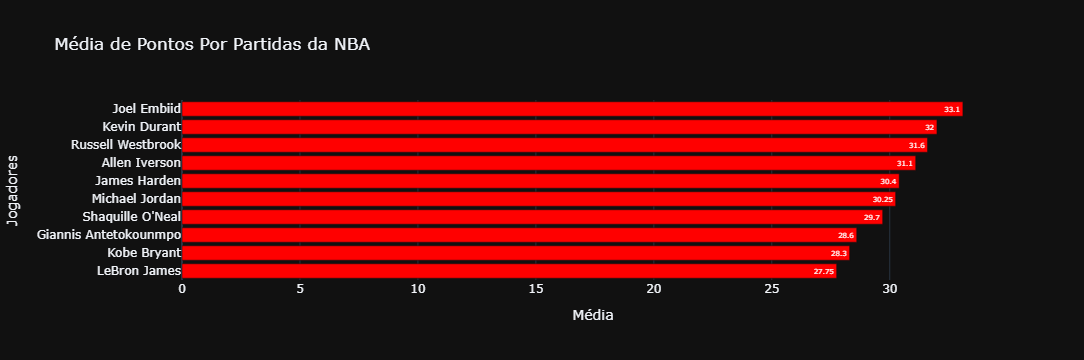

In [84]:
PTS = go.Figure(data=[go.Bar(y=PTS.index, x=PTS.values, orientation='h', text=PTS.values, marker_color='red'), ])
PTS.update_layout(
template='plotly_dark',
title='Média de Pontos Por Partidas da NBA', xaxis_title= 'Média', yaxis_title= 'Jogadores')

#### Total de vitórias por clubes

In [85]:

TW7 = data.groupby('team')['W'].sum().sort_values().tail(10)
TW7

team
Portland Trail Blazers    22332
Dallas Mavericks          22492
Indiana Pacers            22752
Phoenix Suns              22892
Boston Celtics            23218
Los Angeles Lakers        23560
Houston Rockets           23727
Utah Jazz                 24060
Miami Heat                24128
San Antonio Spurs         26719
Name: W, dtype: int64

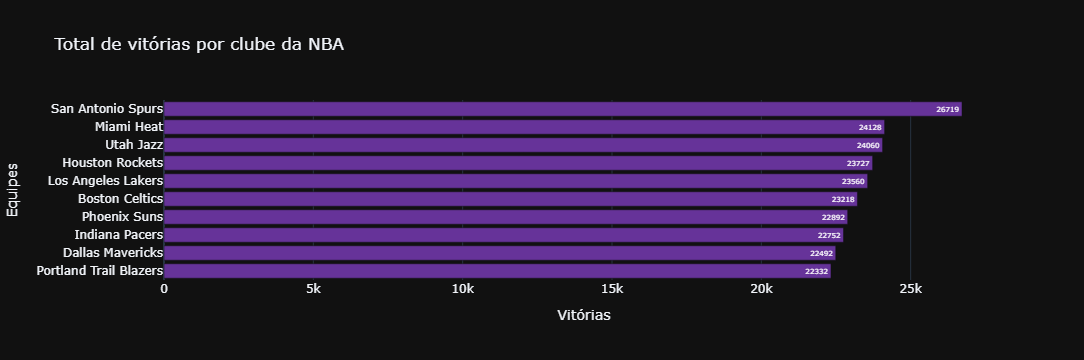

In [86]:
TW7 = go.Figure(data=[go.Bar(y=TW7.index, x=TW7.values, orientation='h', text=TW7.values, marker_color='rebeccapurple'), ])
TW7.update_layout(
template='plotly_dark',
title='Total de vitórias por clube da NBA', xaxis_title= 'Vitórias', yaxis_title= 'Equipes')

#### Distribuição do SHARE MVP jogadores mais votados.

In [87]:
ShareTotal = data.groupby('Player')['Share'].sum().sort_values().tail(10)
ShareTotal

Player
Kevin Durant             3.211
Karl Malone              3.589
James Harden             3.655
Nikola Jokić             3.673
Giannis Antetokounmpo    3.705
Kobe Bryant              4.202
Tim Duncan               4.278
Shaquille O'Neal         4.380
Michael Jordan           5.219
LeBron James             8.818
Name: Share, dtype: float64

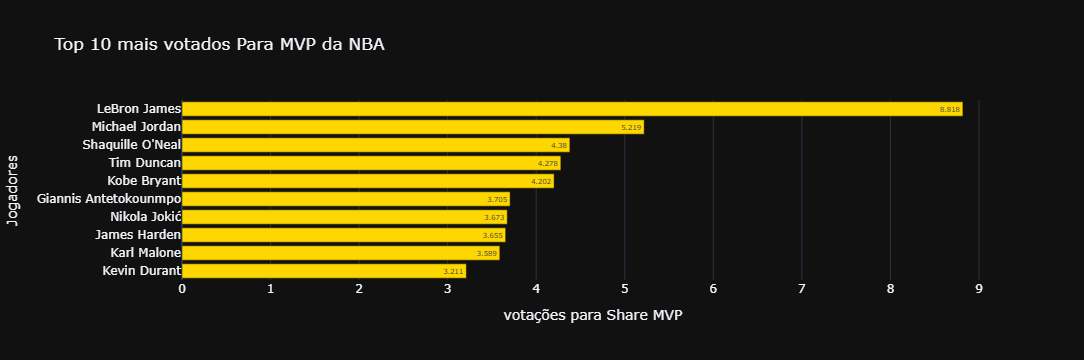

In [88]:
tw = go.Figure(data=[go.Bar(y=ShareTotal.index, x=ShareTotal.values, orientation='h', text=ShareTotal.values, marker_color='gold'), ])
tw.update_layout(
template='plotly_dark',
title='Top 10 mais votados Para MVP da NBA', xaxis_title= 'votações para Share MVP', yaxis_title= 'Jogadores')

#### Verificando se há algum tipo de outlier

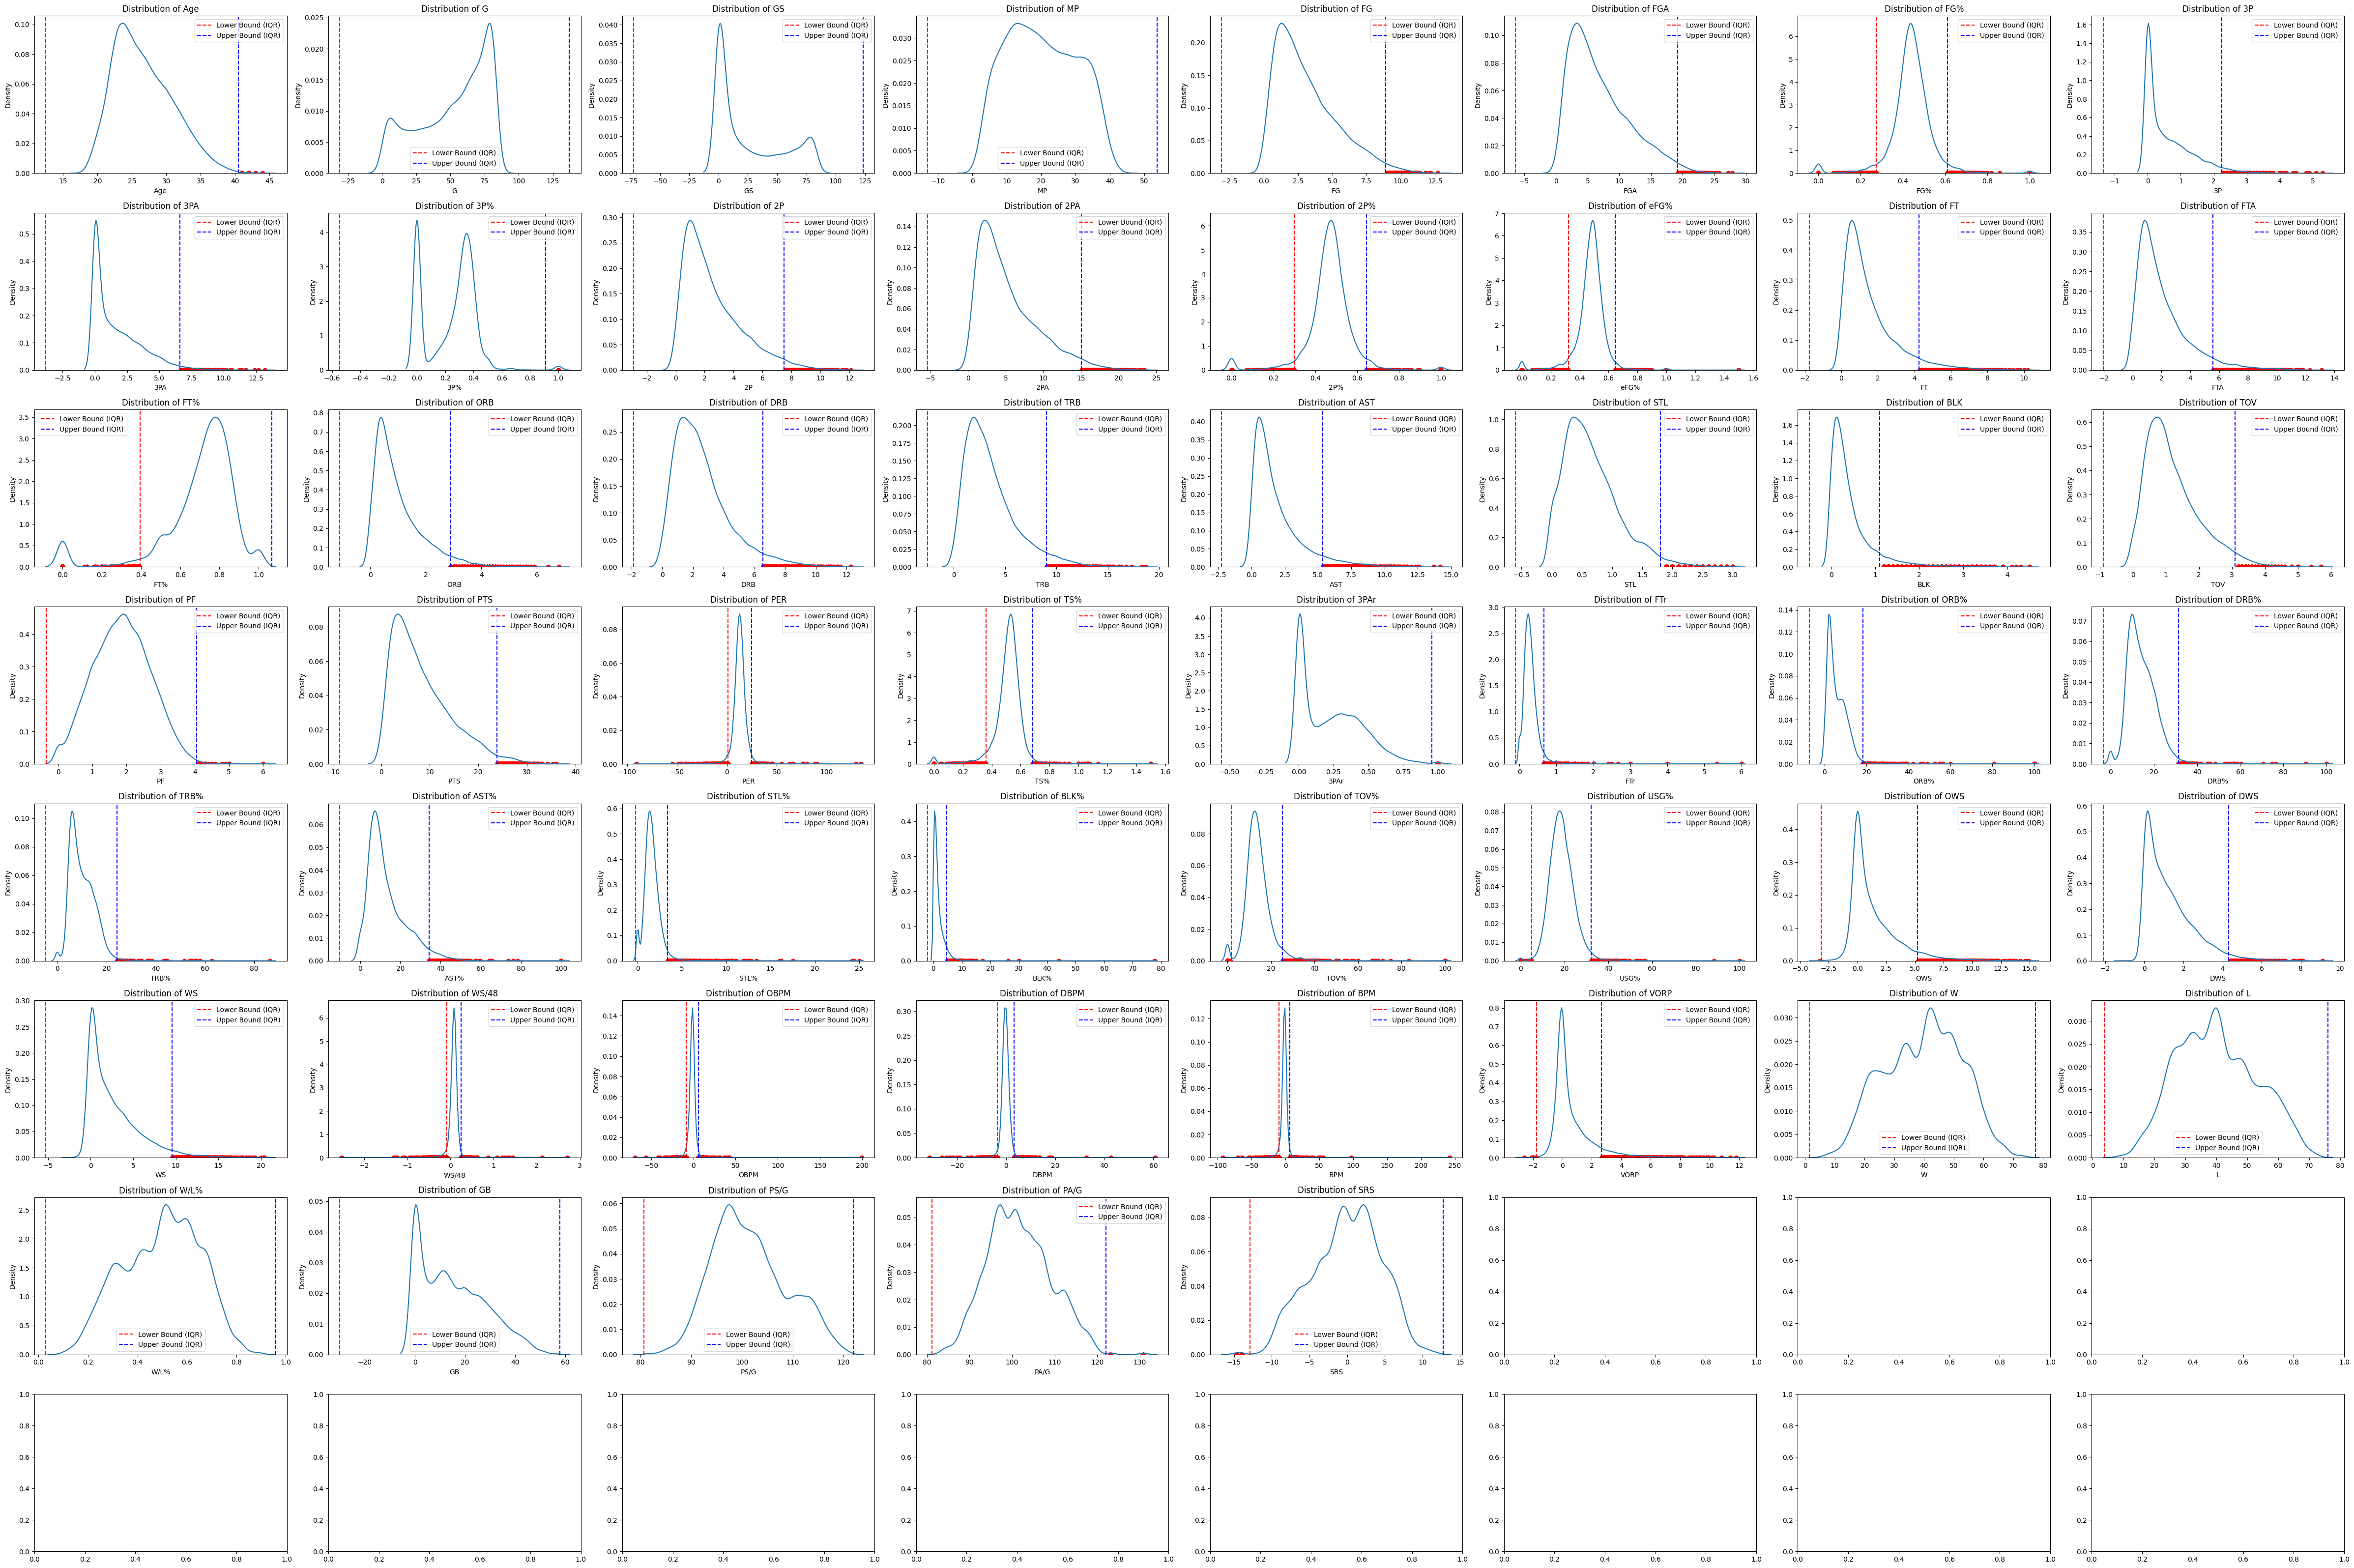

In [67]:
fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(48, 32))
axes = ax.flatten()

for i, col in enumerate(X_train_num.columns):
    sns.kdeplot(X_train_num[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    

    q1 = np.percentile(X_train_num[col], 25)
    q3 = np.percentile(X_train_num[col], 75)
    iqr = q3 - q1
    

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr


    axes[i].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound (IQR)')
    axes[i].axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound (IQR)')
    
 
    outliers = X_train_num[(X_train_num[col] < lower_bound) | (X_train_num[col] > upper_bound)]
    axes[i].scatter(outliers[col], np.zeros_like(outliers[col]), color='red')

    axes[i].legend()

plt.tight_layout()
plt.show()

#### Podemos ver que nenhum registro foi encontrado de jogadores que arremesaram muito mas tiveram poucos jogos

In [68]:
train[(train['3PA'] > 10.0)&(train['G']< 20)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,team,W,L,W/L%,GB,PS/G,PA/G,SRS


Não foi encontrado nesse filtro outiliers

#### Mais outro 5 registros de outliers encontradas na métrica de eficiencia dos arremessos, acima de 100% não existe

In [69]:
train[(train['eFG%']>1.0)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,team,W,L,W/L%,GB,PS/G,PA/G,SRS
442,Jordan Sibert,SG,26,ATL,1,0,4.0,1.0,1.0,1.0,...,0.0,0.0,Atlanta Hawks,29,53,0.354,13.0,113.3,119.4,-6.06
3580,Tyson Wheeler,PG,23,DEN,1,0,3.0,1.0,1.0,1.0,...,0.0,0.0,Denver Nuggets,14,36,0.280,23.0,93.5,100.1,-6.67
4764,Dajuan Wagner,SG,23,GSW,1,0,7.0,1.0,1.0,1.0,...,0.0,0.0,Golden State Warriors,42,40,0.512,19.0,106.5,106.9,0.00
9072,Anthony Brown,SF,25,MIN,1,0,4.0,1.0,1.0,1.0,...,0.0,0.0,Minnesota Timberwolves,47,35,0.573,2.0,109.5,107.3,2.35
15039,Naz Mitrou-Long,SG,24,UTA,1,0,1.0,1.0,1.0,1.0,...,0.0,0.0,Utah Jazz,48,34,0.585,1.0,104.1,99.8,4.47


#### Mais outras 17 sequencias de outliers encontradas. De jogadores que parciparam de mais de 45% da posse de bola e jogaram menos de 20 partidas na temporada.

In [70]:
train[(train['USG%'] > 45) & (train['G'] < 20)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,team,W,L,W/L%,GB,PS/G,PA/G,SRS
79,Howard Nathan,PG,24,ATL,5,0,3.0,1.0,1.8,0.556,...,0.0,0.0,Atlanta Hawks,46,36,0.561,26.0,98.3,97.1,1.29
513,Donovan Williams,SG,21,ATL,2,0,2.0,1.0,2.5,0.400,...,0.0,0.0,Atlanta Hawks,41,41,0.500,3.0,118.4,118.1,0.32
1875,Jack Haley,C,32,CHI,1,0,7.0,2.0,6.0,0.333,...,0.0,0.0,Chicago Bulls,72,10,0.878,0.0,105.2,92.9,11.80
3574,Kelly McCarty,SG,23,DEN,2,0,2.0,1.0,1.5,0.667,...,0.0,0.0,Denver Nuggets,14,36,0.280,23.0,93.5,100.1,-6.67
5491,Terrence Jones,PF,27,HOU,2,0,2.5,0.5,2.0,0.250,...,0.0,0.0,Houston Rockets,53,29,0.646,0.0,113.9,109.1,4.96
6371,Von Wafer,SF,21,LAC,1,0,1.0,0.0,1.0,0.000,...,0.0,0.0,Los Angeles Clippers,40,42,0.488,21.0,95.6,96.1,-0.07
6770,Shea Seals,SG,22,LAL,4,0,2.3,0.3,2.0,0.125,...,0.0,0.0,Los Angeles Lakers,61,21,0.744,0.0,105.5,97.8,6.88
7945,DeAndre Liggins,SG,25,MIA,1,0,1.0,1.0,1.0,1.000,...,0.0,0.0,Miami Heat,54,28,0.659,0.0,102.2,97.4,4.15
9309,Gheorghe Mureșan,C,27,NJN,1,0,1.0,0.0,1.0,0.000,...,0.0,0.0,New Jersey Nets,16,34,0.320,17.0,91.4,95.2,-3.20
9444,Mile Ilić,C,22,NJN,5,0,1.2,0.0,0.6,0.000,...,0.0,0.0,New Jersey Nets,41,41,0.500,6.0,97.6,98.3,-1.00


Foram encontradas 17 registros de outilers.

#### Removendo Registros Inconsistentes

In [71]:
idx_to_drop = train[
    (train['3P%'] > 0.8) & (train['G']<20)|
    (train['STL%'] > 7.5) & (train['G'] < 20)|
    (train['BPM'] > 50) & (train['G'] < 20)|
    (train['DBPM'] > 8) & (train['G'] < 20)|
    (train['OBPM'] > 30) & (train['G'] < 20)|
    (train['DBPM'] < -20) & (train['G'] < 20)|
    (train['OBPM'] < -30) & (train['G'] < 20)|
    (train['WS/48']>0.3) & (train['G'] < 20)|
    (train['WS/48'] < -0.4) & (train['G'] < 20)|
    (train['DRB%'] > 40) & (train['G'] < 20)|
    (train['ORB%'] > 30) & (train['G'] < 20)|
    (train['USG%'] > 45) & (train['G'] < 20)|
    (train['TOV%']>60)|
    (train['BLK%']>40)|
    (train['AST%']>60)|
    (train['TRB%']>45)|
    (train['TS%']>1)|
    (train['PER']>45)|
    (train['PER']<-40)|
    (train['eFG%']>1.0)
    
].index.tolist()

In [72]:
len(idx_to_drop)

249

In [73]:
X_train_dropped = X_train.drop(index=idx_to_drop)
y_train_dropped = y_train.drop(index=idx_to_drop)

In [74]:
X_train_dropped.shape

(14987, 58)

In [75]:
print('Shape of X train after dropped:', X_train_dropped.shape)
X_train_dropped.shape

Shape of X train after dropped: (14987, 58)


(14987, 58)

In [41]:
train.shape

(15236, 61)

In [76]:
X_train_num, X_train_cat = split_numerical_categorical(data=X_train_dropped,num_cols=num_column,cat_cols=cat_column)

Data num shape: (14987, 53)
Data cat shape: (14987, 1)


In [43]:
X_train_cat.isna().sum()

Pos    0
dtype: int64

### Criando DATAFRAME pra ver se as estatisticas descritivas mudaram, com a remoção dos outliers

In [77]:
df_train_dropped = pd.concat([X_train_dropped, y_train_dropped], axis=1)

### Estatisticas Descritivas Pós remoção dos outliers

#### Média de pontos por partidas de jogadores top 10 - Pós outliers

In [241]:
PTS = df_train_dropped.groupby('Player')['PTS'].median().sort_values().tail(10)
PTS

Player
Devin Booker             26.10
Shaquille O'Neal         26.20
Trae Young               26.20
Allen Iverson            26.60
LeBron James             27.15
Giannis Antetokounmpo    27.30
Joel Embiid              27.50
Kevin Durant             27.70
Luka Dončić              28.40
Michael Jordan           29.60
Name: PTS, dtype: float64

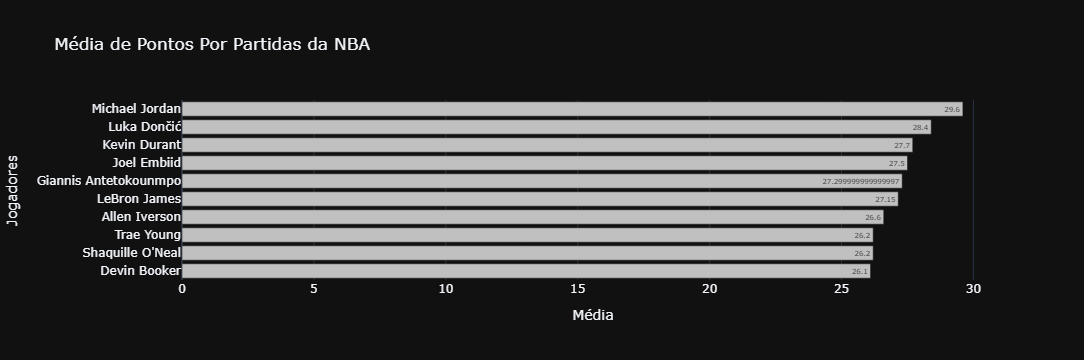

In [242]:
PTS = go.Figure(data=[go.Bar(y=PTS.index, x=PTS.values, orientation='h', text=PTS.values, marker_color='silver'), ])
PTS.update_layout(
template='plotly_dark',
title='Média de Pontos Por Partidas da NBA', xaxis_title= 'Média', yaxis_title= 'Jogadores')

Vemos que teve muita mudança, e saíram alguns outiliers. E a mudança do Michael jordan volta como o Primeiro. Também LeBron James sobe como top 6. 

#### Total de vitórias por clubes - Pós outliers

In [250]:
TW = df_train_dropped.groupby('team')['W'].sum().sort_values().tail(10)
TW

team
Dallas Mavericks          21109
Indiana Pacers            21435
Phoenix Suns              21507
Boston Celtics            21627
Portland Trail Blazers    21748
Los Angeles Lakers        22236
Houston Rockets           22731
Miami Heat                22743
Utah Jazz                 23171
San Antonio Spurs         25990
Name: W, dtype: int64

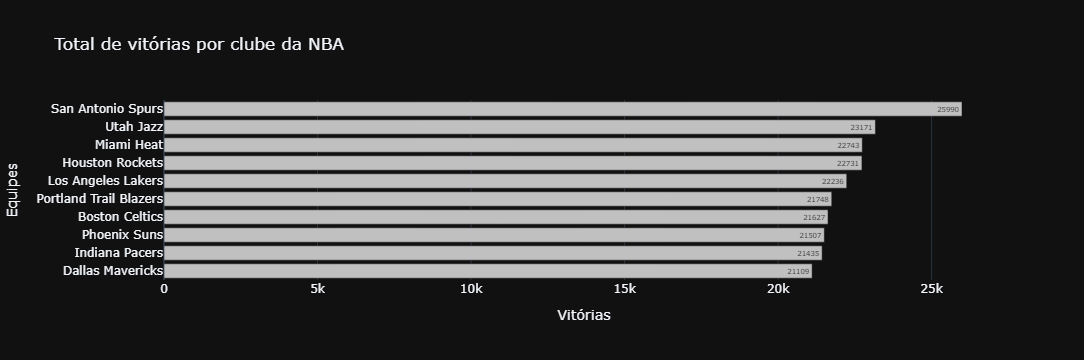

In [251]:
TW = go.Figure(data=[go.Bar(y=TW.index, x=TW.values, orientation='h', text=TW.values, marker_color='silver')])
TW.update_layout(
template='plotly_dark',
title='Total de vitórias por clube da NBA', xaxis_title= 'Vitórias', yaxis_title= 'Equipes')

Ouve algumas alterações nas equipes após a detecção de outliers, alguns valores baixaram. Como vemos nos San Antonio Spurs, e nos demais

#### Distribuição do SHARE MVP jogadores mais votados - Pós outiliers

In [130]:
ShareTotal = df_train_dropped.groupby('Player')['Share'].sum().sort_values().tail(10)
ShareTotal

Player
David Robinson           3.012
Kevin Durant             3.210
Giannis Antetokounmpo    3.511
Karl Malone              3.589
James Harden             3.655
Kobe Bryant              4.202
Tim Duncan               4.278
Shaquille O'Neal         4.380
Michael Jordan           5.219
LeBron James             8.818
Name: Share, dtype: float64

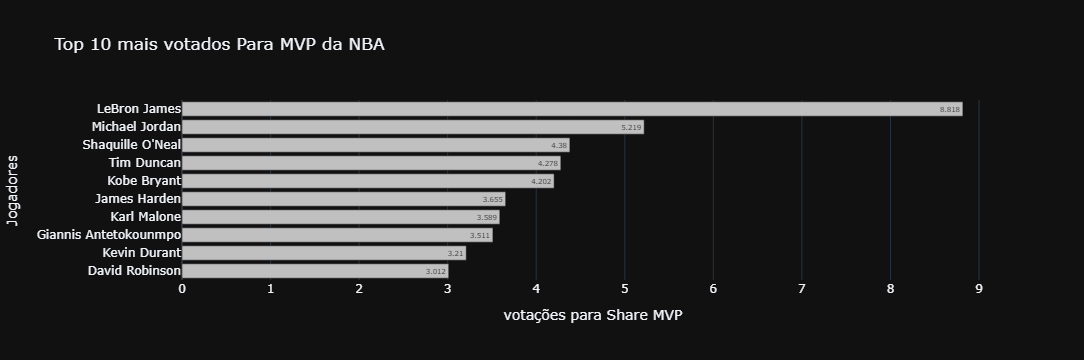

In [136]:
tw = go.Figure(data=[go.Bar(y=ShareTotal.index, x=ShareTotal.values, orientation='h', text=ShareTotal.values, marker_color='silver'), ])
tw.update_layout(
template='plotly_dark',
title='Top 10 mais votados Para MVP da NBA', xaxis_title= 'votações para Share MVP', yaxis_title= 'Jogadores')

No gráfico das estrelas, de votação mvp não ouve nenhuma alteração

### Códificação de Variaveis Categóricas -  OneHotEncoder

#### função para transformação de dados categóricos para numéricos

In [140]:
def cat_OHE_encoder_fit(data):
    ''' 
    Aplicando Onehotencoder nos dados categóricos

    Parametros

    data : pandas.DataFrame
    DataFrame contendo dados categóricos para serem transformados.

    Retorno

    OneHotEncoder
    Tranformar dados categóricos em numéricos
    '''
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(data)
    return encoder

def cat_OHE_encoder_transform(data, encoder):
    ''' 
    Parametros

    data : pandas.DataFrame
    DataFrame contendo dados categóricos para serem transformados..

    encoder : OneHotEncoder
    Tranformar dados categóricos em numéricos

    Returno

    pandas.DataFrame
    '''
    encoded_array = encoder.transform(data)
    feature_names = encoder.get_feature_names_out()
    cleaned_columns = [col.split('_')[-1] for col in feature_names]
    encoded_data = pd.DataFrame(encoded_array, columns=cleaned_columns, index=data.index)
    return encoded_data

In [141]:
ohe_data = X_train_cat
cat_ohe_encoder = cat_OHE_encoder_fit(ohe_data)
X_train_cat_ohe_encoded = cat_OHE_encoder_transform(ohe_data,cat_ohe_encoder)

#### Função de concatenação para geração do dataframe

In [142]:
def concat_data(num_data, cat_data):
    '''  
    Concatenando dados numéricos e categóricos em um único Dataframe.

    Esta função garante que o indice dos dados numéricos e categóricos correspondam antes da concatenação
    Parametros:
    - num_data (pd.DataFrame): Dataframe contendo dados numéricos
    - cat_data (pd.DataFrame): DataFrame contendo dados categóricos.

    Returno:
    - dataframe_concatenado (pd.DataFrame): DataFrame com dados numéricos e categóricos concatenados ao longo das colunas.
    '''
    if not num_data.index.equals(cat_data.index):
        cat_data = cat_data.reindex(num_data.index)
    concatenated_data = pd.concat([num_data, cat_data], axis=1)
    print(f'Numerical data shape  : {num_data.shape}')
    print(f'Categorical data shape: {cat_data.shape}')
    print(f'Concat data shape     : {concatenated_data.shape}')
    return concatenated_data

In [143]:
X_train_concat = concat_data(X_train_num,X_train_cat_ohe_encoded)

Numerical data shape  : (14987, 53)
Categorical data shape: (14987, 5)
Concat data shape     : (14987, 58)


In [144]:
X_train_concat.head()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,W/L%,GB,PS/G,PA/G,SRS,C,PF,PG,SF,SG
0,29,79,79,32.7,5.6,12.9,0.435,1.1,3.3,0.336,...,0.524,18.0,109.8,109.0,0.72,0.0,0.0,1.0,0.0,0.0
1,31,81,81,38.0,9.5,20.2,0.470,1.0,3.1,0.341,...,0.524,18.0,109.8,109.0,0.72,0.0,0.0,0.0,1.0,0.0
2,25,78,2,14.9,2.2,4.6,0.489,0.0,0.0,0.667,...,0.524,18.0,109.8,109.0,0.72,0.0,0.0,0.0,1.0,0.0
3,23,4,0,2.3,0.0,0.0,0.000,0.0,0.0,0.000,...,0.524,18.0,109.8,109.0,0.72,1.0,0.0,0.0,0.0,0.0
4,28,79,2,23.6,5.0,10.9,0.461,0.2,0.6,0.286,...,0.524,18.0,109.8,109.0,0.72,0.0,0.0,0.0,0.0,1.0


### Normalização dos Dados

#### função para aplicação da normalização

In [146]:
def fit_scaler(data):
    '''  
    Aplicar a o standard scaler nos dados numéricos

    Ésta função calcula a média e o desvio padrão de cada variavel nos dados para padronizalos

    Parametros:
    data (pd.DataFrame): DataFrame contendo dados numéricos

    Returno:
    scaler (StandardScaler): Uma saída que ajusta os dados.
    '''
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler
def transform_scaler(data, scaler):
    '''  
    Transformando os dados com a função

    Esta função transforma os dados com base na média e no desvio padrão

    Parametros:
    data (pd.DataFrame): DataFrame com valores numéricos
    scaler (StandardScaler): cria um objeto que tranforma os dados.

    Returns:
    scaled_data (pd.DataFrame): DataFrame com valores transformados por meio desse retorno.
    '''
    scaled_array = scaler.transform(data)
    scaled_data = pd.DataFrame(scaled_array, index=data.index, columns=data.columns)
    return scaled_data

In [147]:
scaler = fit_scaler(X_train_concat)
X_train_clean = transform_scaler(X_train_concat, scaler)

In [148]:
X_train_clean.shape

(14987, 58)

In [149]:
X_train_num.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS'],
      dtype='object')

#### Função de processamento: Explicação.
- 1. Separa os dados numéricos e categóricos com base nas colunas fornecidas
- 2. Aplica one hot encoder aos dados categóricos
- 3. Concatena os dados numéricos e categóricos codificados em um único dataframe.
- 4. Escala os dados usando o Standard Scaler previamente ajustado
- 5. Exibe os formatos dos dados antes e depois da padronização
- 6. Retorna os dados processados e prontos para usar no modelo

In [150]:
def preprocess_data(data, num_cols,cat_cols,cat_ohe_encoder,scaler):
    num_data = data[num_cols]
    cat_data = data[cat_cols]
    cat_ohe_data_encoded = cat_OHE_encoder_transform(cat_data,cat_ohe_encoder)
    processed_data = concat_data(num_data, cat_ohe_data_encoded)
    print(f"Original data shape:{processed_data.shape}")
    clean_data = transform_scaler(processed_data, scaler)
    print(f'Mapped data shape  : {clean_data.shape}')
    return clean_data

In [151]:
X_train_clean = preprocess_data(
    data=X_train_dropped, 
    num_cols=num_column, 
    cat_cols=cat_column, 
    cat_ohe_encoder = cat_ohe_encoder,
    scaler=scaler
)

Numerical data shape  : (14987, 53)
Categorical data shape: (14987, 5)
Concat data shape     : (14987, 58)
Original data shape:(14987, 58)
Mapped data shape  : (14987, 58)


In [152]:
y_train_dropped.shape

(14987,)

In [153]:
X_test_clean = preprocess_data(
    data=X_test, 
    num_cols=num_column, 
    cat_cols=cat_column, 
    cat_ohe_encoder = cat_ohe_encoder,
    scaler=scaler
)

Numerical data shape  : (572, 53)
Categorical data shape: (572, 5)
Concat data shape     : (572, 58)
Original data shape:(572, 58)
Mapped data shape  : (572, 58)


#### Funçao de extração de resultados da validação cruzada. Retorno
- 1. obtém o melhor score de treinamento
- 2. obtém o melhor score de validação cruzada
- 3. obtém os melhores parametros baseados na busca de validação cruzada

In [154]:
def extract_cv_results(cv_obj):

    best_train_score = -cv_obj.cv_results_['mean_train_score'][cv_obj.best_index_]

    best_valid_score = -cv_obj.best_score_  
    
    best_params = cv_obj.best_params_
    
    return best_train_score, best_valid_score, best_params


#### Utilizando validação cruzada de séries temporais, pois os dados são temporais

In [155]:
tscv = TimeSeriesSplit(n_splits=5)

#### Experimentando PCA, já que os dados tem muitas dimensionalidades

In [156]:
pcas = PCA(n_components=0.95)
X_train_pca = pcas.fit_transform(X_train_clean)
X_test_pca = pcas.transform(X_test_clean)

-------------

# Modelando os Dados

--------
### Random Forest

In [157]:
param_grid = {
       'n_estimators': [133, 135, 137],
       'max_depth': [53,55, 57],
       'min_samples_split': [3,4],
       'min_samples_leaf': [3,4],
       'bootstrap': [True],
       'oob_score': [True]
   }

rfg = RandomForestRegressor(random_state=42)
grid_rfg = GridSearchCV(rfg, param_grid, cv=tscv, n_jobs=-1, 
                        return_train_score=True,
                        scoring='neg_root_mean_squared_error')
grid_rfg.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [53, 55, 57],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [3, 4],
                         'n_estimators': [133, 135, 137], 'oob_score': [True]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

### Resultados obtidos do Randon forest

In [160]:
train_rf, valid_rf, best_param_rf = extract_cv_results(grid_rfg)

print(f'Train score - Random Forest model: {train_rf}')
print(f'Valid score - Random Forest model: {valid_rf}')
print(f'Best Params - Random Forest model: {best_param_rf}')

Train score - Random Forest model: 0.015921727888183097
Valid score - Random Forest model: 0.03543911300748535
Best Params - Random Forest model: {'bootstrap': True, 'max_depth': 53, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 133, 'oob_score': True}


---------------------
### Random Forest com PCA

In [161]:
param_grid_pca = {
    'n_estimators': [133, 135, 137],
    'max_depth': [53, 55, 57],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [3, 4],
    'bootstrap': [True],
    'oob_score': [True]
}

rfg_pca = RandomForestRegressor(random_state=42)
grid_rfg_pca = GridSearchCV(rfg_pca, param_grid_pca, cv=tscv, n_jobs=-1, 
                            return_train_score=True,
                            scoring='neg_root_mean_squared_error')
grid_rfg_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [53, 55, 57],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [3, 4],
                         'n_estimators': [133, 135, 137], 'oob_score': [True]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

### Resultados obtidos do Randon forest com PCA

In [162]:
train_rf_pca, valid_rf_pca, best_param_rf_pca = extract_cv_results(grid_rfg_pca)

print(f'Train score - Random Forest model: {train_rf_pca}')
print(f'Valid score - Random Forest model: {valid_rf_pca}')
print(f'Best Params - Random Forest model: {best_param_rf_pca}')

Train score - Random Forest model: 0.01876848037405832
Valid score - Random Forest model: 0.033148584940853196
Best Params - Random Forest model: {'bootstrap': True, 'max_depth': 53, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 135, 'oob_score': True}


-----------------------------
### XGBOOST

#### Eu preciso converter para o numpy pois sempre ocorre um erro com o X_train.

In [169]:
X_train_array = X_train_clean.to_numpy()

In [170]:
xgboost = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1],
    "gamma": [0.1, 1.0],
    "max_depth": [5, 10]
}

xgboost_reg = GridSearchCV(estimator=xgboost,
                           param_grid=xgboost_param_grid,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True,
                           cv=tscv)

xgboost_reg.fit(X=X_train_array, y=y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.1, 1.0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

### Resultados obtidos do XBOOST

In [171]:
train_xgboost, valid_xgboost, best_param_xgboost = extract_cv_results(xgboost_reg)

print(f'Train score - Decision Tree model: {train_xgboost}')
print(f'Valid score - Decision Tree model: {valid_xgboost}')
print(f'Best Params - Decision Tree model: {best_param_xgboost}')

Train score - Decision Tree model: 0.015148347018875652
Valid score - Decision Tree model: 0.03741735263109608
Best Params - Decision Tree model: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


-------------------------
### XGBOOST com PCA

In [172]:
xgboost_pca = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_param_grid_pca = {
    "n_estimators": [100, 200, 300],
    "eta": [0.01, 0.1], 
    "gamma": [0.1, 1.0],
    "max_depth": [5, 10]
}


xgboost_reg_pca = GridSearchCV(estimator=xgboost,
                      param_grid=xgboost_param_grid,
                      scoring='neg_root_mean_squared_error',
                      return_train_score=True,cv=tscv)
xgboost_reg_pca.fit(X= X_train_pca, y= y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.1, 1.0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

### Resultados obtidos do XBOOST com o PCA

In [173]:
train_xgboost_pca, valid_xgboost_pca, best_param_xgboost_pca = extract_cv_results(xgboost_reg_pca)

print(f'Train score - Decision Tree model: {train_xgboost_pca}')
print(f'Valid score - Decision Tree model: {valid_xgboost_pca}')
print(f'Best Params - Decision Tree model: {best_param_xgboost_pca}')

Train score - Decision Tree model: 0.017642119548591895
Valid score - Decision Tree model: 0.035122174638288955
Best Params - Decision Tree model: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


### Sumário de avaliação dos modelos

Escolhendo o melhor modelo, já que o random forest com o PCA tem o melhor score de validação, ele será o melhor modelo.

In [174]:
summary_df = pd.DataFrame(
    data={
        'model': ['XGB', 'XGB_PCA', 'Random Forest', 'Random Forest_PCA'],
        
        'train_score': [train_xgboost,train_xgboost_pca, train_rf, train_rf_pca],
        
        'valid_score': [valid_xgboost, valid_xgboost_pca, valid_rf, valid_rf_pca],
       
        'best_params': [best_param_xgboost, best_param_xgboost_pca, best_param_rf, best_param_rf_pca]
    }
)

summary_df['train_score'] 
summary_df['valid_score']
summary_df.sort_values(by='valid_score', ascending=True)

,model,train_score,valid_score,best_params
3,Random Forest_PCA,0.018768,0.033149,"{'bootstrap': True, 'max_depth': 53, 'min_samp..."
1,XGB_PCA,0.017642,0.035122,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept..."
2,Random Forest,0.015922,0.035439,"{'bootstrap': True, 'max_depth': 53, 'min_samp..."
0,XGB,0.015148,0.037417,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_dep..."


### Função que verifica o map@k e o RMSE de todos os modelos no conjunto de teste

In [177]:
def calculate_map_k(models, test_sets, y_test, k=5):
    results = {}

    for model_name, model_data in models.items():
        model = model_data['model']
        test_key = model_data['test_set']
        X_test = test_sets[test_key]

        if 'XGB' in model_name and isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()

        predictions = model.predict(X_test)
        predictions = pd.DataFrame(predictions, columns=['predictions'], index=y_test.index)
        
        combination = pd.concat([y_test, predictions], axis=1)
        
        actual = combination.sort_values('Share', ascending=False)
        actual['Rk'] = range(1, len(actual) + 1)
        
        predicted = combination.sort_values('predictions', ascending=False)
        predicted['Rk_predicted'] = range(1, len(predicted) + 1)
        
        comb = pd.merge(actual, predicted[['Rk_predicted']], left_index=True, right_index=True)
        comb.sort_values('Rk', inplace=True)
        
        rmse = mean_squared_error(comb['Share'], comb['predictions'], squared=False)
        
        def apk(actual_rank, predicted_rank, k=5):
            if actual_rank > k:
                return 0
            return max(0, 1 - (abs(actual_rank - predicted_rank) / k))
        
        map_k_scores = [apk(row['Rk'], row['Rk_predicted'], k) for _, row in comb.iterrows()]
        map_k_score = np.mean(map_k_scores)
        
        results[(model_name, test_key)] = {'MAP@K': map_k_score, 'RMSE': rmse}

    return results

O map@k como métrica, por quê é frequentemente utilizado em problemas de ranking ou sistemas de recomendação. Onde o objetivo é a qualidade das top-k previsões

### função de resultados gerais dos modelos

In [176]:
def results_to_dataframe(results):
    results_list = [
        {
            'Model': model_name,
            'Test Set': test_name,
            'MAP@K': scores['MAP@K'],
            'RMSE': scores['RMSE']
        }
        for (model_name, test_name), scores in results.items()
    ]
    df_results = pd.DataFrame(results_list)

    df_results_sorted = df_results.sort_values(by=['MAP@K', 'RMSE'], ascending=[False, True])
    
    return df_results_sorted

In [178]:
models = {
    'XGB': {'model': xgboost_reg, 'test_set': 'UsualTest'},
    'XGB_PCA': {'model': xgboost_reg_pca, 'test_set': 'PCATest'},
    'RandomForest': {'model': grid_rfg, 'test_set': 'UsualTest'},
    'RandomForest_PCA': {'model': grid_rfg_pca, 'test_set': 'PCATest'},
}

test_sets = {
    'UsualTest': X_test_clean,
    'PCATest': X_test_pca,
}

y_test = test[['Player', 'Share', 'year']]

results = calculate_map_k(models, test_sets, y_test, k=5)

In [179]:
df_results_sorted = results_to_dataframe(results)
print(df_results_sorted)

              Model   Test Set     MAP@K      RMSE
0               XGB  UsualTest  0.008042  0.018860
2      RandomForest  UsualTest  0.007692  0.018517
1           XGB_PCA    PCATest  0.006993  0.019628
3  RandomForest_PCA    PCATest  0.006993  0.030107


### Concluindo

O melhor modelo na prática foi o XGBOOST sem o PCA. O Random forest com o PCA pode superar modelos mais simples, como os modelos de regressão linear. Mas em modelos mais complexos, o modelo que não usa o PCA tem um desempenho melhor. Esse experimento mostra que o PCA nem sempre melhorar o desempenho e pode prejudicar modelos mais complexos 

#### Aplicando a função para retornar os resultados dos modelos em um dataframe

In [180]:
df_results_sorted = results_to_dataframe(results)
print(df_results_sorted)

              Model   Test Set     MAP@K      RMSE
0               XGB  UsualTest  0.008042  0.018860
2      RandomForest  UsualTest  0.007692  0.018517
1           XGB_PCA    PCATest  0.006993  0.019628
3  RandomForest_PCA    PCATest  0.006993  0.030107


### Criando um dataframe com as variaveis 'Player', 'Share','year' e as previsões do XBOOST 

In [181]:
X_test_array = X_test_clean.to_numpy()

In [182]:
prediction = xgboost_reg.predict(X_test_array)

In [183]:
prediction = pd.DataFrame(prediction, columns=['predictions'], index=test.index)

In [184]:
coombination = pd.concat([test[['Player', 'Share','year']], prediction], axis=1)

In [185]:
coombination.sort_values('Share',ascending=False).head(9)

,Player,Share,year,predictions
3970,Nikola Jokić,0.935,2024,0.805677
10696,Shai Gilgeous-Alexander,0.646,2024,0.729995
3434,Luka Dončić,0.572,2024,0.453909
8656,Giannis Antetokounmpo,0.194,2024,0.579004
10412,Jalen Brunson,0.143,2024,0.124736
1067,Jayson Tatum,0.087,2024,0.089731
9168,Anthony Edwards,0.018,2024,0.056299
13337,Domantas Sabonis,0.003,2024,0.047049
12294,Kevin Durant,0.001,2024,0.024262


In [186]:
mean_squared_error(coombination['Share'],coombination['predictions'])

0.00035569427182402774

In [187]:
actual = coombination.sort_values('Share', ascending=False)

In [188]:
actual['Rk'] = list(range(1, coombination.shape[0]+1))

In [189]:
actual.head(9)

,Player,Share,year,predictions,Rk
3970,Nikola Jokić,0.935,2024,0.805677,1
10696,Shai Gilgeous-Alexander,0.646,2024,0.729995,2
3434,Luka Dončić,0.572,2024,0.453909,3
8656,Giannis Antetokounmpo,0.194,2024,0.579004,4
10412,Jalen Brunson,0.143,2024,0.124736,5
1067,Jayson Tatum,0.087,2024,0.089731,6
9168,Anthony Edwards,0.018,2024,0.056299,7
13337,Domantas Sabonis,0.003,2024,0.047049,8
12294,Kevin Durant,0.001,2024,0.024262,9


In [190]:
predicted= coombination.sort_values('predictions', ascending=False)

In [191]:
predicted['Rk_predicted'] = list(range(1, coombination.shape[0]+1))

In [192]:
predicted.head(9)

,Player,Share,year,predictions,Rk_predicted
3970,Nikola Jokić,0.935,2024,0.805677,1
10696,Shai Gilgeous-Alexander,0.646,2024,0.729995,2
8656,Giannis Antetokounmpo,0.194,2024,0.579004,3
3434,Luka Dončić,0.572,2024,0.453909,4
10412,Jalen Brunson,0.143,2024,0.124736,5
1067,Jayson Tatum,0.087,2024,0.089731,6
11769,Joel Embiid,0.000,2024,0.070685,7
9168,Anthony Edwards,0.018,2024,0.056299,8
7184,LeBron James,0.000,2024,0.051749,9


In [193]:
comb = pd.concat([actual, predicted['Rk_predicted']], axis=1)

## PREVENDO OS MVPS DA NBA

#### Podemos ver que o modelo realmente melhor conseguiu prever com sucesso os 4 principais candidatos ao MVP da temporada da NBA de 2024

In [134]:
comb.sort_values('Rk').head(9)

,Player,Share,year,predictions,Rk,Rk_predicted
3970,Nikola Jokić,0.935,2024,0.805677,1,1
10696,Shai Gilgeous-Alexander,0.646,2024,0.729995,2,2
3434,Luka Dončić,0.572,2024,0.453909,3,4
8656,Giannis Antetokounmpo,0.194,2024,0.579004,4,3
10412,Jalen Brunson,0.143,2024,0.124736,5,5
1067,Jayson Tatum,0.087,2024,0.089731,6,6
9168,Anthony Edwards,0.018,2024,0.056299,7,8
13337,Domantas Sabonis,0.003,2024,0.047049,8,10
12294,Kevin Durant,0.001,2024,0.024262,9,14


### Trabalhando com a Ferramenta SHAP.

Nesse gráfico do Shap, ele retorna as variaveis que influenciam mais na previsão do modelo. Os valores vermelhos tem mais impactos, os azuis são as que menos influencia. A variavel VORP se destaca como uma influencia significativa.

PermutationExplainer explainer: 573it [11:58,  1.26s/it]                                                               
PermutationExplainer explainer: 573it [10:19,  1.10s/it]                                                               


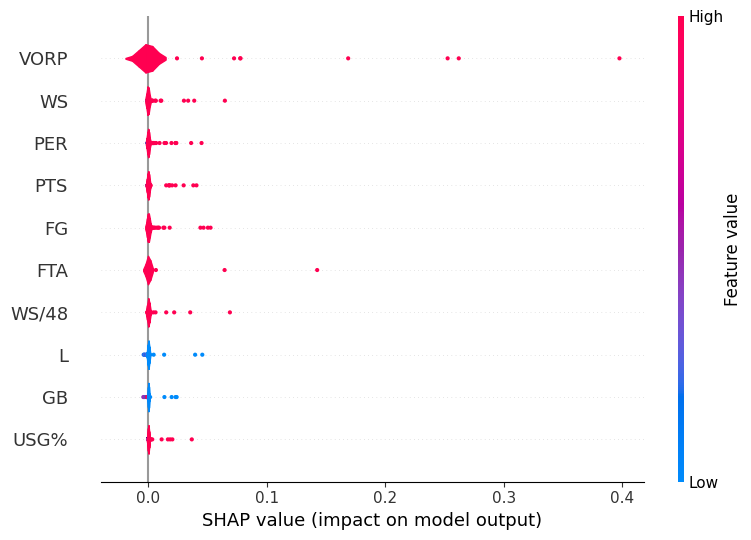

In [194]:
explainer = shap.Explainer(grid_rfg.predict, X_test_clean)

shap_values = explainer.shap_values(X_test_clean)

explainer = shap.Explainer(grid_rfg.predict, X_test_clean)

shap_values = explainer(X_test_clean)

shap.summary_plot(
    shap_values, 
    X_test_clean,
    plot_type="violin",
    color_bar=True,
    max_display=10, 
    show=False
)

### Fechamento

O melhor modelo foi o XBOOST regression, pois ele apresentou a maior métrica de ranking MAP@K e o RMSE chegou proximo do Randon Forest regression.
ele acertou 4 rincipais candidatos para MVP na sua previsão.

In [197]:
import matplotlib.image as mpimg

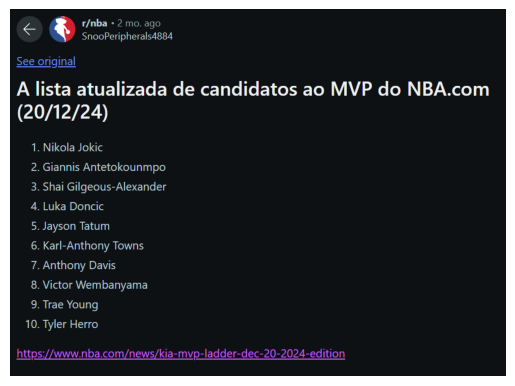

In [198]:
imagem = mpimg.imread(r'C:\Users\Anizio\Desktop\HD atual\FACULDADE ATUALIZADO 2024\NBA_MVPS_2024.png')
plt.imshow(imagem)
plt.axis("off")  # Oculta os eixos
plt.show()

In [199]:
img1 = mpimg.imread(r'C:\Users\Anizio\Desktop\HD atual\FACULDADE ATUALIZADO 2024\NBA_MVPS_2024.png')
img2 = mpimg.imread(r'C:\Users\Anizio\Desktop\HD atual\FACULDADE ATUALIZADO 2024\PREVISÃO DO MODELO PARA MVP.png')

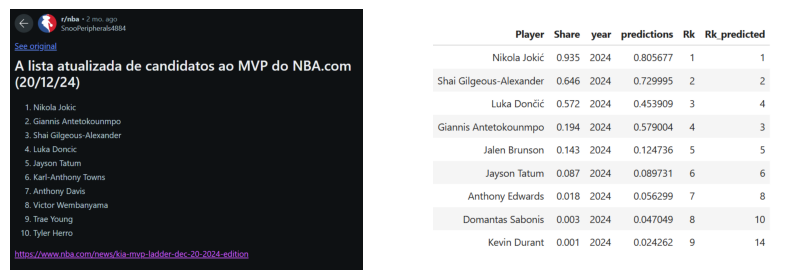

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 linha, 2 colunas

axes[0].imshow(img1)
axes[0].axis("off")  

axes[1].imshow(img2)
axes[1].axis("off")  


plt.show()

### Vemos que ele acertou alguns candidados. Isso provar que o modelo previu com eficiência.

Lista atualizada dos MVPS: 
https://www.reddit.com/r/nba/comments/1hiqkqb/nbacoms_updated_mvp_ladder_122024/?tl=pt-br&rdt=51464
https://www.nba.com/news/kia-mvp-ladder-dec-20-2024-edition

## O MVP

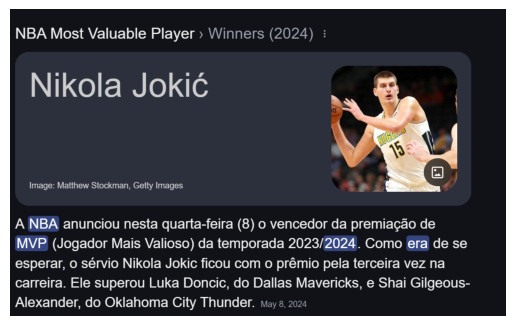

In [201]:
imagemMVP = mpimg.imread(r'C:\Users\Anizio\Desktop\HD atual\FACULDADE ATUALIZADO 2024\O MVP de 2024.png')
plt.imshow(imagemMVP)
plt.axis("off") 
plt.show()

O modelo XGBOOST regression acertou com precisão quem foi.

https://www.google.com/search?q=quem+foi+o+mvp+da+nba+2024&rlz=1C1GCEA_enBR1029BR1029&oq=quem+foi+o+mvp+da+nba+2024&gs_lcrp=EgZjaHJvbWUyEAgAEEUYExg5GEYY-wEYgAQyCggBEAAYExgWGB4yCggCEAAYExgWGB4yCggDEAAYExgWGB4yCggEEAAYExgWGB4yCggFEAAYExgWGB4yCggGEAAYExgWGB4yCggHEAAYExgWGB4yCggIEAAYExgWGB4yCggJEAAYExgWGB7SAQkxMDU5NGowajeoAgCwAgA&sourceid=chrome&ie=UTF-8